In [ ]:
## DATA
# 

In [1]:
import pandas as pd
import statistics 
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [61]:
import keywords

In [3]:
articles_df = pd.read_csv('articles/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [4]:
articles_df.shape

(3047, 13)

In [40]:
interactions_df = pd.read_csv('articles/users_interactions.csv')
interactions_df = interactions_df[['timestamp','eventType', 'contentId','personId','sessionId']]
interactions_df = interactions_df[interactions_df['contentId'].isin(articles_df['contentId'])]

### Convert interaction to our cases and to Rating

In [41]:
change_interaction = {
   'VIEW': 'CLICK',
   'LIKE': 'EXPLICIT', 
   'BOOKMARK': 'SAVE', 
   'FOLLOW': 'TIME_OPEN',
   'COMMENT CREATED': 'RECOMMEND',  
}

interactions_df.eventType = interactions_df.eventType.apply(lambda x: change_interaction[x])

values_interaction = {
    'CLICK' : 2.0,
    'EXPLICIT' : 5.0,
    'SAVE': 3.0,
    'TIME_OPEN': 3.0,
    'RECOMMEND': 3.5
}

interactions_df['rating'] = interactions_df['eventType'].apply(lambda x: values_interaction[x])
users_ids = list(interactions_df.personId.unique())

### Order sessions by timestamp and  subset function

In [50]:
interactions_ordered = interactions_df.sort_values(by='timestamp', ascending=True) 

In [104]:
def get_subset(df_full_ordered, number):
    interactions = df_full_ordered.iloc[0:number,:].groupby(['personId', 'contentId'])['rating'].mean().reset_index()
    interactions.rating = interactions.rating.round()
    um = interactions.pivot(index='personId', columns='contentId', values='rating').fillna(0)
    return um, interactions

## Overall sparsity function

In [100]:
def get_overall_sparsity(ut_matrix):
    A = np.array(ut_matrix)
    sparsity = round(1.0 - (np.count_nonzero(A) / float(A.size) ), 4)
    return sparsity


### Partition of interactions - to inspect data

In [106]:
sparsities = []
subs = []
number_users = []
number_items = []
m3 = []
for i in range(0, round(interactions_ordered.shape[0]/1000), 2):
    if i < 70 and i != 0 :
        N_interactions = i*1000
    if i == 70  and i != 0:
        N_interactions = interactions_ordered.shape[0]
    else:
        pass
    subs.append(N_interactions)
    utility_matrix, interactions_subset = get_subset(interactions_ordered, N_interactions)
    ids_users = list(interactions_subset.personId.unique())
    ids_items = list(interactions_subset.contentId.unique())
    sparsities.append(get_overall_sparsity(utility_matrix))
    number_users.append(len(ids_users))
    number_items.append(len(ids_items))

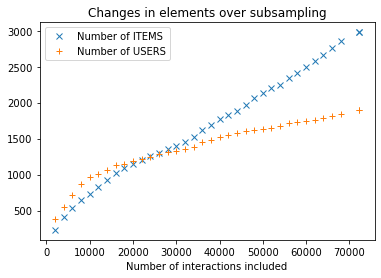

In [111]:
x = subs
y = [number_items, number_users]
labels = ['Number of ITEMS' , 'Number of USERS']
markers = ['x' , '+']

for i,j in enumerate(y):
    plt.plot(x, j, markers[i], label= labels[i])
plt.title('Changes in elements over subsampling')
plt.xlabel('Number of interactions included')
plt.legend(numpoints=1)

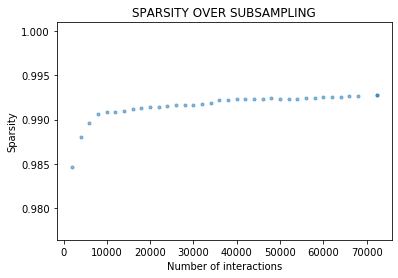

In [110]:
area = np.pi*3
plt.scatter(subs, sparsities, s=area, alpha=0.5)
plt.title('SPARSITY OVER SUBSAMPLING')
plt.xlabel('Number of interactions included')
plt.ylabel('Sparsity')
plt.show()

In [53]:
matrix, interactions_final = get_subset(interactions_ordered, 1000)
matrix.head()

contentId,-9171475473795142532,-9157338616628196758,-9137036168156595470,-9107331682787867601,-9100490342054218852,-9083294960368598209,-8939172344092554931,-8773118241761372618,-8349788035147634450,-8287402887944984163,...,8095004770374551394,8194079557551008273,8219310215587599928,8298709454703868984,8471417198703153120,8545647269051113523,8565115980515859979,8742078838645536785,9032993320407723266,9122627895188486603
personId,,,,,,,,,,,,,,,,,,,,,
-9016528795238256703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9009798162809551896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9001583565812478106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8994220765455693336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-8909668725653743114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
with open('interactions.pkl', 'wb') as f:  
    pickle.dump([matrix, interactions_final], f)

In [56]:
matrix.shape

(234, 129)

## METRICS

### M1 - User activity for this subset

In [65]:
USER = -8909668725653743114

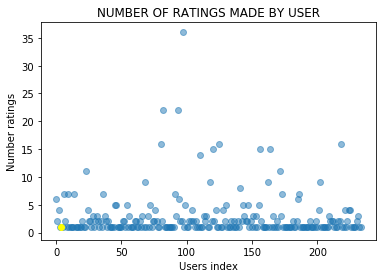

In [78]:
users = list(matrix.index)
ratings_users = []
for user in users:
    user_ratings = matrix.shape[1] - (matrix == 0).astype(int).sum(axis=1)[user]
    ratings_users.append(user_ratings)
    

x = range(len(ratings_users))
y = ratings_users
index_user  = users.index(USER)
plt.scatter(x, y, alpha=0.5)
plt.scatter(index_user, ratings_users[index_user], color="yellow")
plt.title('NUMBER OF RATINGS MADE BY USER')
plt.xlabel('Users index')
plt.ylabel('Number ratings')
plt.show()

In [73]:
dev_users = statistics.stdev(ratings_users)
med_users = statistics.median(ratings_users)
mean_users = statistics.mean(ratings_users)
print("DEVIATION = {} \nMEDIAN = {} \nMEAN = {}".format(dev_users,med_users,mean_users))

DEVIATION = 4.0 
MEDIAN = 1 
MEAN = 2


In [87]:
def get_metric1(user, ut_matrix):
    "Number of items that the user has rated devided by the maximum number of items rated by an user"
    "Comparison between my activity and the most active user"
    "Number of users remain almost the same - comparable in the same time"
    user_no_ratings = ut_matrix.shape[1] - (ut_matrix == 0).astype(int).sum(axis=1)[user]
    max_ratings_by_an_user = ut_matrix.shape[1] - min((ut_matrix == 0).astype(int).sum(axis=1))
    return round(user_ratings/max_ratings_by_an_user, 3)


In [88]:
M1 = get_metric1(USER, matrix)

## M3 - Items activity for this subset

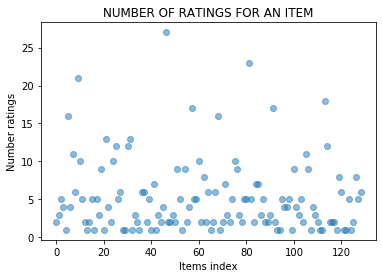

In [79]:
items = list(matrix.columns)
ratings_items = []
for item in items:
    item_ratings = matrix.shape[0] - (matrix == 0).astype(int).sum(axis=0)[item]
    ratings_items.append(item_ratings)
    
x = range(len(items))
y = ratings_items
plt.scatter(x, y, alpha=0.5)
plt.title('NUMBER OF RATINGS FOR AN ITEM')
plt.xlabel('Items index')
plt.ylabel('Number ratings')
plt.show() 
    

In [74]:
dev_items = statistics.stdev(ratings_items)
med_items = statistics.median(ratings_items)
mean_items = statistics.mean(ratings_items)
print("DEVIATION = {} \nMEDIAN = {} \nMEAN = {}".format(dev_items,med_items,mean_items))

DEVIATION = 4.69041575982343 
MEDIAN = 4.0 
MEAN = 5


In [81]:
# max_ratings_for_item = matrix.shape[0] - min((matrix == 0).astype(int).sum(axis=0))

In [29]:
def get_metric3(ut_matrix):
    "proportion of items rated by more than 5% users"
    items = list(ut_matrix.columns)
    list_ratings_items = []
    for item in items:
        item_ratings = ut_matrix.shape[0] - (ut_matrix == 0).astype(int).sum(axis=0)[item]
        list_ratings_items.append(item_ratings)
    number_users = ut_matrix.shape[0]
    N = 0.05*number_users
    more_than_N = [it for it in list_ratings_items if it >= N]
    return round(len(more_than_N)/len(list_ratings_items),3)

In [86]:
M3 = get_metric3(matrix)

## M4- Items descriptors

In [62]:
with open('tfidf.pkl', 'rb') as f:  
    tfidf_matrix, tfidf_feature_names, full_item_ids = pickle.load(f)

In [72]:
items = list(matrix.columns)
topn = 10
qualities = []
for it in items:
    qualities.append(keywords.get_keywords(full_item_ids, tfidf_matrix, tfidf_feature_names, topn, it)[1])

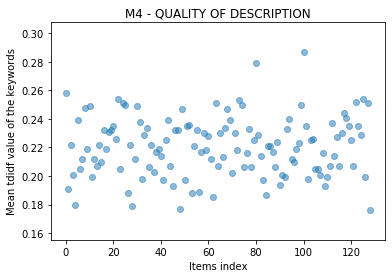

In [80]:
x = range(len(items))
y = qualities
plt.scatter(x, y, alpha=0.5)
plt.title('M4 - QUALITY OF DESCRIPTION')
plt.xlabel('Items index')
plt.ylabel('Mean TDIDF value of the keywords')
plt.show() 

In [82]:
dev_items2 = statistics.stdev(qualities)
med_items2 = statistics.median(qualities)
mean_items2 = statistics.mean(qualities)
print("DEVIATION = {} \nMEDIAN = {} \nMEAN = {}".format(dev_items2,med_items2,mean_items2))

DEVIATION = 0.02075571976831387 
MEDIAN = 0.221 
MEAN = 0.22071317829457365


In [85]:
M4 = round(mean_items2,3)

In [89]:

len(more_than_N)


max_ratings_for_an_item = utility_matrix.shape[0] - min((utility_matrix == 0).astype(int).sum(axis=0))
print(max_ratings_for_an_item)
#np.percentile(np.array(more_than_N), 50)
# item = 0
# user_test = -9001583565812478106
# item_test = -9171475473795142532
# user = user_test
# m1 = get_metric1(user, utility_matrix)
# m2_ = get_item_m2(item_test, utility_matrix)

#v2 = get_item_m2(items, utility_matrix)

134

In [86]:
#statistics.variance(ratings_items)


len(ratings_items)
# var_m2 = statistics.variance(v2)
# mean_m2 = statistics.mean(v2) 
# med_m2 = statistics.median(v2)
# med_m2

231

In [64]:
mean_m2
#session_content = interactions_df.groupby(['timestamp', 'sessionId', 'contentId'])['rating'].mean().reset_index()
#user_content = interactions_df.groupby(['personId', 'contentId'])['rating'].mean().reset_index()
#len(session_content)

# interactions_user_content = user_content.set_index('personId')
# session_content.head()

0.15887878787878787

In [65]:

# def get_items_interacted(person_id, user_interactions_df):
#     interacted_items = user_interactions_df.loc[person_id]['contentId']
#     return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])
#interactions_df.groupby(['personId', 'sessionId']).size()


In [66]:
#interactions_df.groupby(['personId', 'sessionId']).size()[-8845298781299428018].to_dict()
#interactions_df[interactions_df['sessionId']==-9220390249094144275]


# dict_sessions = {}
# for user in users_ids:
#     sessions = list(interactions_df.groupby(['personId', 'sessionId']).size()[user].to_dict().keys())
#     dict_sessions[user] = sessions


In [67]:
#len(interactions_df.sessionId.unique())
#len(interactions_df[interactions_df['personId']==-9223121837663643404].sessionId.unique())

#count_by_session = pd.DataFrame(interactions_df.groupby(['sessionId']).size())
#interactions_df.groupby(['sessionId', 'contentId']).size() #['eventStrength'].sum().apply(smooth_user_preference).reset_index()


In [114]:
interactions_df

1895

In [2]:
# interactions_df.personId.unique()
# by_user = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
# int_user = interactions_df[interactions_df['personId']==-9223121837663643404]
# by_user

### Simulate timestamp